# 生成对抗模仿学习

## 1.背景介绍
    1.1.论文背景
    1.2.读前先问
    1.3.强化学习背景
## 2.论文思想
    2.1.模仿学习
    2.2.行为克隆和逆强化学习
    2.3.生成对抗模仿学习
    2.4.实验结果
## 3.代码实践
    3.1.Step 1.生成专家数据
    3.2 Step 2.行为克隆
    3.3 Step 3.生成对抗模仿学习
## 4.总结回顾

---

## 1.背景介绍

### 1.1.论文背景

论文地址：[Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476)

1. [Jonathan Ho](http://www.jonathanho.me/)
- 履历：
    - 2009年，加利福尼亚大学研究助理
    - 2010年，Google软件工程实习生
    - 2011年，Microsoft软件开发实习生
    - 2012年，Facebook软件工程实习生
    - 2017年，OpenAI研究科学家
    - 2019年，Google研究实习生
    - 2020年，Google研究科学家、加利福尼亚大学伯克利分校计算机科学博士
- 研究方向：
    - 无监督学习和强化学习


2. [Stefano Ermon](https://cs.stanford.edu/~ermon/)
- 履历：
    - 斯坦福大学计算机科学副教授
- 研究方向：
    - 概率建模、生成学习和推理，专注于将计算机科学与其它学科联系起来的新领域，以解决可持续性的核心问题，包括减贫、粮食安全和可再生能源

<img src="https://cs.stanford.edu/~ermon/IMG_8217_s_1.jpg" width="210" height="262">

## 1.2.读前先问

1. 大方向的任务是什么？
- 强化学习，让模型学习最优决策。

2. 这个方向有什么问题？是什么类型的问题？
- 对于复杂场景智能体学习太慢。
- 奖励函数难以定义，依赖于现实环境的规则，智能体可能找到某些漏洞。

3. 为什么会有这些问题？
- 智能体开始学习时为探索环境选择随机动作，导致花费大量的时间探索。
- 现实世界的规则不能详尽，导致奖励函数难以定义。

4. 作者是怎么解决这个问题的？
- 模仿学习可以通过专家经验快速学习，减少了探索的时间
- 专家经验中包括了潜在的规则

5. 怎么验证解决方案是否有效？
- 论文中：模型达到专家效果所需要的数据集大小
- 考察学习速度：模型达到相同效果所需要的时间是否更短
- 考察占用度量：相同状态下智能体采取的动作和专家采取的动作相同的重合率

## 1.3.强化学习

 ![](./images/3-6-2.png)

1. 随机过程

**随机过程**：一连串随机现象动态关系的定量描述，研究对象是随时间演变的随机现象。

**随机现象**在某个时刻t的取值是一个向量，用$S_{t}$表示，所有可能的状态组成状态集合$S$。

已知历史信息，下一时刻的状态为$S_{t+1}$的概率：$P(S_{t+1}|S_{1},...,S_{t})$。

2. 马尔可夫性质

**马尔可夫性质**：某时刻的状态只取决于上一时刻的状态。→ $P(S_{t+1}|S_{t}) = P(S_{t+1}|S_{1},...,S_{t})$

3. 马尔可夫过程

**马尔可夫过程**：具有马尔可夫性质的随机过程，通常用元组`(S, P)`表示。

$$
\mathcal{P}=\left[\begin{array}{ccc}
P\left(s_{1} \mid s_{1}\right) & \cdots & P\left(s_{n} \mid s_{1}\right) \\
\vdots & \ddots & \vdots \\
P\left(s_{1} \mid s_{n}\right) & \cdots & P\left(s_{n} \mid s_{n}\right)
\end{array}\right]
$$

4. 马尔可夫奖励过程

**马尔可夫奖励过程**：在马尔可夫过程的基础上再加入奖励函数`r`和折扣因子`γ`，由元组`(S, P, r, γ)`组成。

**价值函数**：一个状态的期望回报被称为这个状态的价值，所有状态的价值组成价值函数。

5. 马尔可夫决策过程

**马尔可夫决策过程**：在马尔可夫奖励过程的基础上再加入智能体的动作，由元组`(S, P, A, r, γ)`组成，$r(s, a)$是奖励函数，$P(s'|s, a)$是状态转移函数。

**策略**：$\pi(a|s)=P(A_{t}=a|S_{t}=s)$，表示在输入状态为s的情况下采取动作a的概率。

**状态价值函数**：从状态$s$出发遵循策略$\pi$能获得的期望回报，$V^{\pi}(s)=E_{\pi}[G_{t}|S_{t}=s]$。

**动作价值函数**：在使用策略$\pi$时，对当前状态$s$执行动作$a$得到的期望回报，$Q^{\pi}(s,a)=E_{\pi}[G_{t}|S_{t}=s, A_{t}=a]$。

6. 占用度量

不同策略的价值函数是不一样的，因为智能体访问到的状态的概率分布式不一样的。

**占用度量**：在执行策略$\pi$时状态动作对`(s, a)`被访问到的概率。

# 2.论文思想

强化学习的数据是通过智能体与环境的交互得到的，虽然并不需要有监督学习中的标签，但是很依赖奖励函数的设置。

在很多现实场景中，奖励函数难以确定，需要经过精心设计和调试。

模仿学习通过直接模仿专家在环境中交互的状态动作数据来训练智能体的策略。

目前学术界模仿学习的方法基本上可以分为三类：
1. 行为克隆（Behavior Cloning, BC）：直接使用监督学习的方法，应用专家数据`(S, A)`。
- `s`为输入，`a`为标签，学习的目标为：$\theta^{*} = \arg \min_{\theta} E_{(s,a)\sim B}[L(\pi_{\theta}(s), a)]$。

2. 逆强化学习（Inverse Reinforcement Learning, IRL）：假设环境奖励函数应使专家轨迹获得最高奖励值，进而学习背后的奖励函数，最后基于该奖励函数进行正向强化学习，从而得到模仿策略。
- 逆强化学习的优化函数：$\underset{c \in \mathcal{C}}{\operatorname{maximize}}\left(\min _{\pi \in \Pi}-H(\pi)+\mathbb{E}_{\pi}[c(s, a)]\right)-\mathbb{E}_{\pi_{E}}[c(s, a)]$，其中$H(\pi) \triangleq \mathbb{E}_{\pi}[-\log \pi(a \mid s)]$。

3. 生成对抗模仿学习（Generative Adversarial Imitation Learning, GAIL）：基于生成对抗网络直接从数据中学习策略，绕过了中间逆强化学习的步骤。
- 尽量使得学习的策略在环境中的所有状态动作对的占用度量$\rho_{\pi}(s,a)$和专家策略的占用度量$\rho_{\pi_{E}}(s,a)$一致。
- 判别器D的损失函数：$L(\phi)=-E_{\rho_{\pi}}[\log D_{\phi}(s, a)] - E_{\rho_{E}}[log(1-D_{\phi}(s, a))]$

## 实验结果

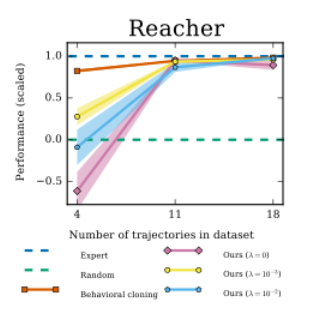
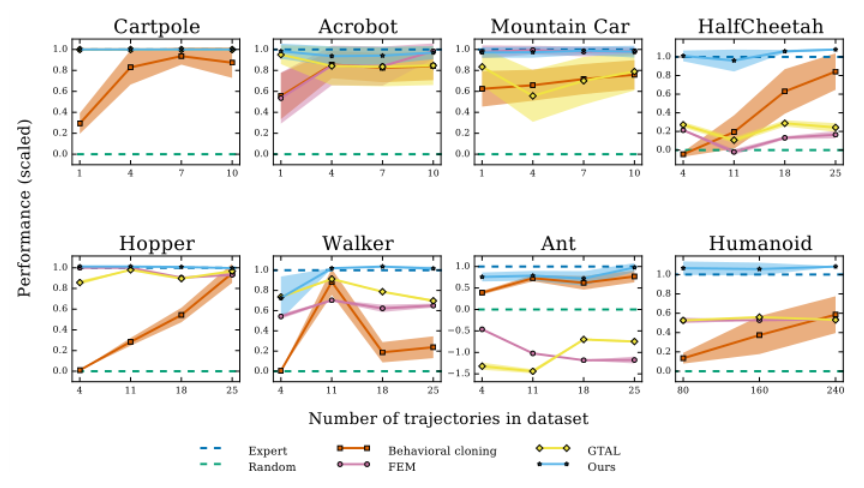

# 3.代码实践

## Step 1.生成专家数据

In [3]:
import random

import gym
import torch as th
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torch.nn import functional as F

In [4]:
class PolicyNet(nn.Module):
	def __init__(self, state_dim, hidden_dim, action_dim):
		super(PolicyNet, self).__init__()
		self.fc1 = nn.Linear(state_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, action_dim)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		return F.softmax(self.fc2(x), dim=1)

In [5]:
class ValueNet(nn.Module):
	def __init__(self, state_dim, hidden_dim):
		super(ValueNet, self).__init__()
		self.fc1 = nn.Linear(state_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, 1)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		return self.fc2(x)

In [6]:
def compute_advantage(gamma, lambda_, td_delta):
	td_delta = td_delta.cpu().detach().numpy()
	advantage_list = []
	advantage = 0.0
	for delta in td_delta[::-1]:
		advantage = gamma * lambda_ * advantage + delta
		advantage_list.append(advantage)
	advantage_list.reverse()
	return th.tensor(advantage_list, dtype=th.float)

In [7]:
class PPO:
	""" PPO算法，采用截断方式 """

	def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma):
		self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
		self.critic = ValueNet(state_dim, hidden_dim).to(device)
		self.actor_optimizer = th.optim.Adam(self.actor.parameters(), lr=actor_lr)
		self.critic_optimizer = th.optim.Adam(self.critic.parameters(), lr=critic_lr)
		self.gamma = gamma
		self.lambda_ = lambda_
		self.epochs = epochs
		self.eps = eps

	def take_action(self, state):
		state = th.tensor([state], dtype=th.float).to(device)
		probs = self.actor(state)
		action_dist = th.distributions.Categorical(probs)
		action = action_dist.sample()
		return action.item()

	def update(self, transition_dict):
		states = th.tensor(transition_dict["states"], dtype=th.float).to(device)
		actions = th.tensor(transition_dict["actions"], dtype=th.float).view(-1, 1).to(device)
		rewards = th.tensor(transition_dict["rewards"], dtype=th.float).view(-1, 1).to(device)
		next_states = th.tensor(transition_dict["next_states"], dtype=th.float).to(device)
		dones = th.tensor(transition_dict["dones"], dtype=th.float).view(-1, 1).to(device)
		td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones).to(device)
		td_delta = td_target - self.critic(states)
		advantage = compute_advantage(self.gamma, self.lambda_, td_delta).to(device)
		old_log_probs = th.log(self.actor(states).gather(1, actions.type(th.int64))).detach()

		for _ in range(self.epochs):
			log_probs = th.log(self.actor(states).gather(1, actions.type(th.int64)))
			ratio = th.exp(log_probs - old_log_probs)
			surr1 = ratio * advantage
			surr2 = th.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
			actor_loss = th.mean(-th.min(surr1, surr2))
			critic_loss = th.mean(F.mse_loss(self.critic(states), td_target.detach()))
			self.actor_optimizer.zero_grad()
			self.critic_optimizer.zero_grad()
			actor_loss.backward()
			critic_loss.backward()
			self.actor_optimizer.step()
			self.critic_optimizer.step()

In [8]:
def train_on_policy_agent(env, agent, num_episodes):
	return_list = []
	for i in range(epochs):
		with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
			for i_episode in range(int(num_episodes / 10)):
				episode_return = 0
				transition_dict = {"states": [], "actions": [], "next_states": [], "rewards": [], "dones": []}
				state = env.reset()
				done = False
				while not done:
					action = agent.take_action(state)
					next_state, reward, done, _ = env.step(action)

					transition_dict["states"].append(state)
					transition_dict["actions"].append(action)
					transition_dict["next_states"].append(next_state)
					transition_dict["rewards"].append(reward)
					transition_dict["dones"].append(done)
					state = next_state
					if -0.4 < next_state[0] < 0.5:
					    reward = 10 * (next_state[0] + 0.4) ** 3
					elif next_state[0] >= 0.5:
					    reward = 100
					else:
					    reward = -0.1
					episode_return += reward
				return_list.append(episode_return)
				agent.update(transition_dict)
				if (i_episode + 1) % 10 == 0:
					pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
					                  'return': '%.3f' % np.mean(return_list[-10:]),
                                      'reward': '%.3f' % reward})
				pbar.update(1)
	return return_list

In [9]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 300
hidden_dim = 128
gamma = 0.98
lambda_ = 0.95
epochs = 10
eps = 0.2

device = th.device("cuda") if th.cuda.is_available() else th.device("cpu")
env = gym.make("MountainCar-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma)

print(f"device: {device}")

device: cpu


D:\repo\reinforcementlearning\venv\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
D:\repo\reinforcementlearning\venv\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [10]:
return_list = train_on_policy_agent(env, ppo_agent, num_episodes)

Iteration 0:   0%|          | 0/30 [00:00<?, ?it/s]D:\repo\reinforcementlearning\venv\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  from ipykernel import kernelapp as app
Iteration 9: 100%|██████████| 30/30 [00:05<00:00,  5.70it/s, episode=300, return=-5.914, reward=0.002]


In [11]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        state = env.reset()
        done = False
        while not done:
            action = ppo_agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            if -0.4 < next_state[0] < 0.5:
                reward = 10 * (next_state[0] + 0.4) ** 3
            elif next_state[0] >= 0.5:
                reward = 100
            else:
                reward = -0.1

    return np.array(states), np.array(actions)

In [12]:
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 30  # 采样30个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

## Step 2.行为克隆

In [13]:
class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = th.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = th.tensor(states, dtype=th.float).to(device)
        actions = th.tensor(actions).view(-1, 1).to(device)
        log_probs = th.log(self.policy(states).gather(1, actions.type(th.int64)))
        bc_loss = th.mean(-log_probs)  # 最大似然估计

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

    def take_action(self, state):
        state = th.tensor([state], dtype=th.float).to(device)
        probs = self.policy(state)
        action_dist = th.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()


def test_agent(agent, env, n_episode):
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            if -0.4 < next_state[0] < 0.5:
                reward = 10 * (next_state[0] + 0.4) ** 3
            elif next_state[0] >= 0.5:
                reward = 100
            else:
                reward = -0.1
            episode_return += reward
        return_list.append(episode_return)
    return np.mean(return_list)

In [14]:
lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 500
batch_size = 32
test_returns = []

with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0, high=expert_s.shape[0], size=batch_size)
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 500/500 [04:48<00:00,  1.73it/s, return=-5.380]


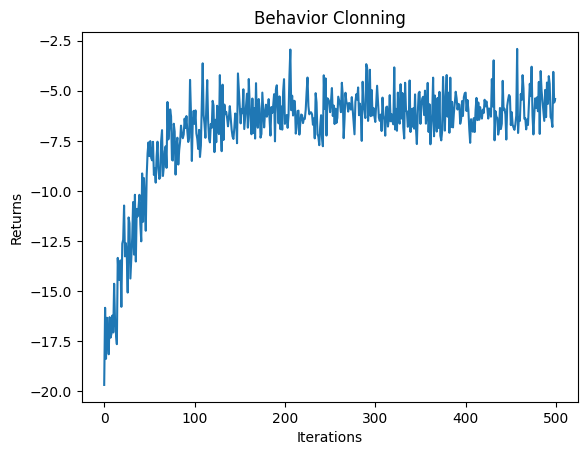

In [15]:
iteration_list = list(range(len(test_returns)))
plt.plot(iteration_list, test_returns)
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title("Behavior Clonning")
plt.show()

## Step 3.生成对抗模仿学习

In [16]:
class Discriminator(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Discriminator, self).__init__()
        self.fc1 = th.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = th.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = th.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        return th.sigmoid(self.fc2(x))

In [17]:
class GAIL:
    def __init__(self, agent, state_dim, action_dim, hidden_dim, lr_d):
        self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
        self.discriminator_optimizer = th.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.agent = agent

    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones):
        expert_states = th.tensor(expert_s, dtype=th.float).to(device)
        expert_actions = th.tensor(expert_a, dtype=th.int64).to(device)
        agent_states = th.tensor(agent_s, dtype=th.float).to(device)
        agent_actions = th.tensor(agent_a, dtype=th.int64).to(device)
        expert_actions = F.one_hot(expert_actions, num_classes=3).float()
        agent_actions = F.one_hot(agent_actions, num_classes=3).float()

        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)
        discriminator_loss = nn.BCELoss()(agent_prob, th.ones_like(agent_prob)) + nn.BCELoss()(expert_prob, th.zeros_like(expert_prob))
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -th.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)

In [21]:
lr_d = 1e-3
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 500
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            if -0.4 < next_state[0] < 0.5:
                reward = 10 * (next_state[0] + 0.4) ** 3
            elif next_state[0] >= 0.5:
                reward = 100
            else:
                reward = -0.1
            episode_return += reward

        return_list.append(episode_return)
        gail.learn(expert_s, expert_a, state_list, action_list, next_state_list, done_list)
        if np.mean(return_list[-10:]) >= -6:
            env.render()
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

进度条:  19%|█▉        | 95/500 [00:14<01:05,  6.19it/s, return=-7.710] D:\repo\reinforcementlearning\venv\lib\site-packages\gym\core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "
进度条: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s, return=-5.986]


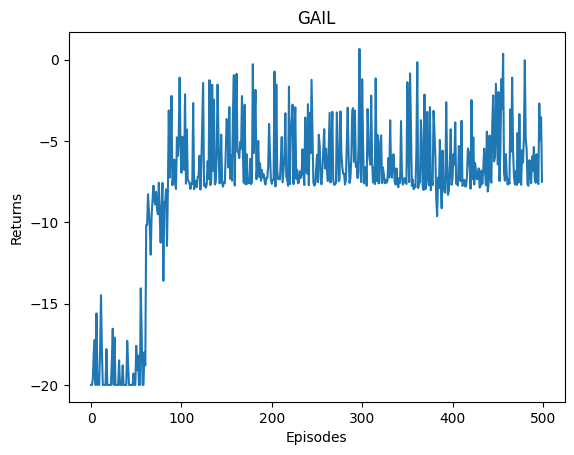

In [22]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("GAIL")
plt.show()

# 4.总结回顾

1. 学到了什么？

生成对抗网络+强化学习

2. 还有什么不懂？

最大因果熵IRL

3. 发现了什么问题？

- 生成对抗模仿学习的效果虽然提升的快但是不稳定，波动很大。
- 模仿学习本身需要确保专家经验一定是正确的，否则子模型可能会在父模型的基础上继续偏移，上梁不正下梁歪。
- 还是没有办法判断知识的重要性。

4. 能不能应用？

正在尝试~